
# Deep Learning Driven Malaria Detection System 
Architect: SIDDHARTH CHADDA
---



In [ ]:
#Copyright [2021] [Owner: Siddharth Chadda]

#Licensed under the Apache License, Version 2.0 (the "License");
#you may not use this file except in compliance with the License.
#You may obtain a copy of the License at

#    http://www.apache.org/licenses/LICENSE-2.0

#Unless required by applicable law or agreed to in writing, software
#distributed under the License is distributed on an "AS IS" BASIS,
#WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#See the License for the specific language governing permissions and
#limitations under the License.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing data from My google drive
!pip install patool

     |████████████████████████████████| 77 kB 2.5 MB/s 


In [ ]:
import patoolib
patoolib.extract_archive('/content/drive/MyDrive/cell_images.zip',outdir='/content/')

patool: Extracting /content/drive/MyDrive/cell_images.zip ...
patool: running /usr/bin/7z x -o/content/ -- /content/drive/MyDrive/cell_images.zip
patool: ... /content/drive/MyDrive/cell_images.zip extracted to `/content/'.


'/content/'

In [ ]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1650159955626041823
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3694128328658553979
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]


ORIGINAL DATA SOURCE:

The dataset contains 2 folders - Infected - Uninfected

And a total of 27,558 images.


This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/ 


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
# Technically not necessary in newest versions of jupyter
%matplotlib inline

In [ ]:
my_data_dir = '/content/cell_images'

In [ ]:

os.listdir(my_data_dir) 

['test', 'train']

In [ ]:
test_path = my_data_dir+'/test'
train_path = my_data_dir+'/train'

In [ ]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [ ]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [ ]:
os.listdir(train_path+'/parasitized')[0]

'C97P58ThinF_IMG_20150917_151903_cell_7.png'

In [ ]:
para_cell = train_path+'/parasitized'+'/C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [ ]:
para_img= imread(para_cell)

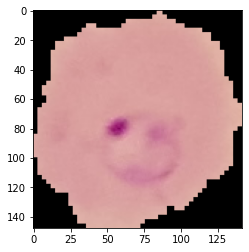

In [ ]:
plt.imshow(para_img)

In [ ]:
para_img.shape

(148, 142, 3)

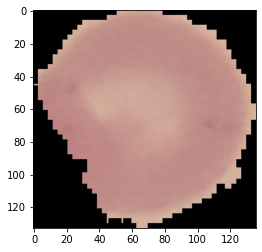

In [ ]:
unifected_cell_path = train_path+'/uninfected/'+os.listdir(train_path+'/uninfected')[11]
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell)

**Let's check how many images there are.**

In [ ]:
len(os.listdir(train_path+'/parasitized'))

12480

In [ ]:
len(os.listdir(train_path+'/uninfected'))

12480

**Calculating the average dimensions of these images.**

In [ ]:
unifected_cell.shape

(133, 136, 3)

In [ ]:
para_img.shape

(148, 142, 3)

In [ ]:
# Other options: https://stackoverflow.com/questions/1507084/how-to-check-dimensions-of-all-images-in-a-directory-using-python
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'/uninfected'):
    
    img = imread(test_path+'/uninfected'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


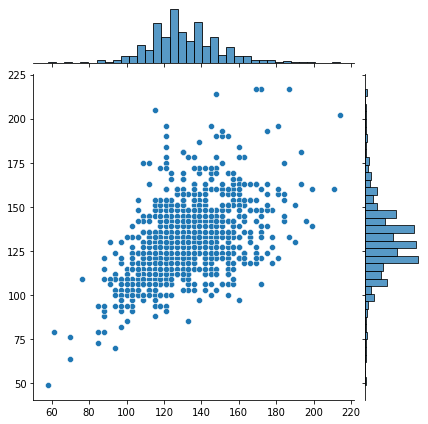

In [ ]:
sns.jointplot(dim1,dim2)

In [ ]:
np.mean(dim1)

130.92538461538462

In [ ]:
np.mean(dim2)

130.75

In [ ]:
image_shape = (130,130,3)

## Preparing the Data for the model

### Image Manipulation using ImageGenerator Piplines


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

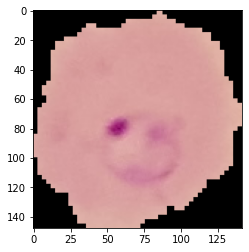

In [ ]:
plt.imshow(para_img)

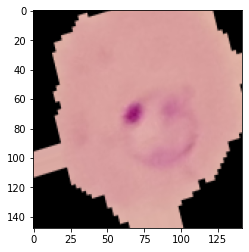

In [ ]:
plt.imshow(image_gen.random_transform(para_img))

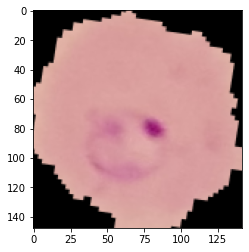

In [ ]:
plt.imshow(image_gen.random_transform(para_img))

### Generating many manipulated images from a directory

### Note To Self:
In order to use .flow_from_directory, we must organize the images in sub-directories. This is an absolute requirement, otherwise the method won't work. The directories should only contain images of one class, so one folder per class of images.

# Defining the Driectory Structure Required:

* Image Data Folder
    * Class 1
        * 0.jpg
        * 1.jpg
        * ...
    * Class 2
        * 0.jpg
        * 1.jpg
        * ...
    * ...
    * Class n

In [ ]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [ ]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


# Creating the Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [ ]:
#https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

## Early Stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

## Training the Model

In [ ]:
batch_size = 16

In [ ]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [ ]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [ ]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
results = model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/20
1560/1560 [==============================] - 167s 101ms/step - loss: 0.3997 - accuracy: 0.8161 - val_loss: 0.1899 - val_accuracy: 0.9396
Epoch 2/20
1560/1560 [==============================] - 162s 104ms/step - loss: 0.1788 - accuracy: 0.9453 - val_loss: 0.1757 - val_accuracy: 0.9412
Epoch 3/20
1560/1560 [==============================] - 158s 101ms/step - loss: 0.1736 - accuracy: 0.9463 - val_loss: 0.1560 - val_accuracy: 0.9496
Epoch 4/20
1560/1560 [==============================] - 158s 101ms/step - loss: 0.1645 - accuracy: 0.9485 - val_loss: 0.1542 - val_accuracy: 0.9504
Epoch 5/20
1560/1560 [==============================] - 156s 100ms/step - loss: 0.1591 - accuracy: 0.9499 - val_loss: 0.1755 - val_accuracy: 0.9404
Epoch 6/20
1560/1560 [==============================] - 157s 100ms/step - loss: 0.1600 - accuracy: 0.9494 - val_loss: 0.1527 - val_accuracy: 0.9496
Epoch 7/20
1560/1560 [==============================] - 158s 101ms/step - loss: 0.1569 - accuracy: 0.9495 - val_

In [ ]:
from tensorflow.keras.models import load_model
model.save('malaria_detector.h5')

# Evaluating the Model

In [ ]:
losses = pd.DataFrame(model.history.history)


In [ ]:
model.metrics_names

['loss', 'accuracy']

In [ ]:
model.evaluate_generator(test_image_gen)

[0.15433958172798157, 0.9523077011108398]

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
# https://datascience.stackexchange.com/questions/13894/how-to-get-predictions-with-predict-generator-on-streaming-test-data-in-keras
pred_probabilities = model.predict_generator(test_image_gen)

In [ ]:
pred_probabilities

array([[1.2376633e-03],
       [3.1248917e-04],
       [5.4417025e-05],
       ...,
       [9.7562683e-01],
       [9.6476275e-01],
       [9.9065381e-01]], dtype=float32)

In [ ]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
predictions = pred_probabilities > 0.5

In [ ]:
# Numpy can treat this as True/False for us
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1300
           1       0.92      0.97      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [ ]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1197,  103],
       [  39, 1261]])

# Predicting on an Image

In [ ]:
my_image = image.load_img(para_cell,target_size=image_shape)

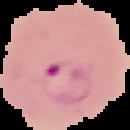

In [ ]:
my_image

In [ ]:
type(my_image)

PIL.Image.Image

In [ ]:
my_image = image.img_to_array(my_image)

In [ ]:
type(my_image)

numpy.ndarray

In [ ]:
my_image.shape

(130, 130, 3)

In [ ]:
my_image = np.expand_dims(my_image, axis=0)

In [ ]:
my_image.shape

(1, 130, 130, 3)

In [ ]:
model.predict(my_image)

array([[0.]], dtype=float32)

In [ ]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [ ]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

##Building a LeNet Architecture based CNN

In [ ]:
from tensorflow.keras.layers import AveragePooling2D
LeNet_model = Sequential()
# Layer 1 Conv2D
LeNet_model.add(Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=image_shape, padding="same"))
# Layer 2 Pooling Layer
LeNet_model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
# Layer 3 Conv2D
LeNet_model.add(Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
# Layer 4 Pooling Layer
LeNet_model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
LeNet_model.add(Flatten())
LeNet_model.add(Dense(units=120, activation='tanh'))
LeNet_model.add(Dense(units=84, activation='tanh'))

LeNet_model.add(Dense(1))
LeNet_model.add(Activation('sigmoid'))
LeNet_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
LeNet_results = LeNet_model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/20
1560/1560 [==============================] - 156s 99ms/step - loss: 0.7075 - accuracy: 0.4972 - val_loss: 0.7020 - val_accuracy: 0.5000
Epoch 2/20
1161/1560 [=====================>........] - ETA: 35s - loss: 0.6948 - accuracy: 0.5099

KeyboardInterrupt: ignored

##Building Oxford VDD Architecture based CNN

In [ ]:
from tensorflow.keras.layers import MaxPool2D

OX_model = Sequential()
OX_model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=image_shape))
OX_model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
OX_model.add(MaxPool2D(pool_size=2,strides=2,padding='valid'))

OX_model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
OX_model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
OX_model.add(MaxPool2D(pool_size=2,strides=2,padding='valid'))

OX_model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
OX_model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
OX_model.add(MaxPool2D(pool_size=2,strides=2,padding='valid'))

OX_model.add(Flatten())
OX_model.add(Dense(units=128, activation='relu'))
OX_model.add(Dropout(0.5))

OX_model.add(Dense(1))
OX_model.add(Activation('sigmoid'))
OX_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
OX_results = OX_model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/20
1560/1560 [==============================] - 204s 129ms/step - loss: 0.6933 - accuracy: 0.4964 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/20
  27/1560 [..............................] - ETA: 2:48 - loss: 0.6928 - accuracy: 0.5231

KeyboardInterrupt: ignored

In [ ]:
Custom_model = Sequential()
Custom_model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=image_shape))
Custom_model.add(MaxPool2D(pool_size=2,strides=2,padding='valid'))

Custom_model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
Custom_model.add(MaxPool2D(pool_size=2,strides=2,padding='valid'))

Custom_model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
Custom_model.add(MaxPool2D(pool_size=2,strides=2,padding='valid'))


Custom_model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
Custom_model.add(MaxPool2D(pool_size=2,strides=2,padding='valid'))


Custom_model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
Custom_model.add(MaxPool2D(pool_size=2,strides=2,padding='valid'))

Custom_model.add(Flatten())
Custom_model.add(Dense(units=128, activation='relu'))
Custom_model.add(Dropout(0.5))

Custom_model.add(Dense(1))
Custom_model.add(Activation('sigmoid'))
Custom_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
Custom_results = Custom_model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/20
1560/1560 [==============================] - 157s 100ms/step - loss: 0.2454 - accuracy: 0.9000 - val_loss: 0.1636 - val_accuracy: 0.9504
Epoch 2/20
1560/1560 [==============================] - 155s 100ms/step - loss: 0.1591 - accuracy: 0.9505 - val_loss: 0.1564 - val_accuracy: 0.9512
Epoch 3/20
1560/1560 [==============================] - 159s 102ms/step - loss: 0.1524 - accuracy: 0.9528 - val_loss: 0.1465 - val_accuracy: 0.9500
Epoch 4/20
1560/1560 [==============================] - 152s 98ms/step - loss: 0.1467 - accuracy: 0.9545 - val_loss: 0.1395 - val_accuracy: 0.9531
Epoch 5/20
1560/1560 [==============================] - 152s 97ms/step - loss: 0.1414 - accuracy: 0.9554 - val_loss: 0.1419 - val_accuracy: 0.9538
Epoch 6/20
1560/1560 [==============================] - 152s 98ms/step - loss: 0.1389 - accuracy: 0.9557 - val_loss: 0.1529 - val_accuracy: 0.9473


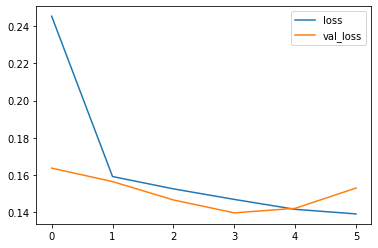

In [ ]:
pd.DataFrame(Custom_model.history.history)[['loss','val_loss']].plot()